In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import blahut

In [2]:
def get_raw_data(path):
    """
    Load raw data from a path.
    Parameters
    ----------
    path : str
        Absolute path to the data.
    Returns
    -------
    Vs : np.array, shape (len(data),)
    Rs : np.array, shape (len(data),)
    """
    data = pd.read_pickle(path)
    Vs = np.array(data['V'])
    Rs = np.array(data['R'])
    return Vs,Rs

def range_extender(Vs, Rs, num_ext):
    """
    Extends the range of the memristor function so that the min and max R values are
    repeated num_ext times past min and max V
    Parameters
    ----------
    Vs : np.array, shape (len(data),)
    Rs : np.array, shape (len(data),)
    num_ext : float
        Number of times the end values should be repeated
    """
    num_ext = int(num_ext)
    Vs = np.array(Vs)
    Rs = np.array(Rs)
    delta_V = Vs[1]-Vs[0]
    orig_min_Vs = np.amin(Vs)
    orig_max_Vs = np.amax(Vs)
    for i in range(num_ext):
        min_Vs = np.amin(Vs)
        max_Vs = np.amax(Vs)
        min_Vs_indx = [Vs == min_Vs]
        max_Vs_indx = [Vs == max_Vs]
        Rs_min = Rs[tuple(min_Vs_indx)]
        Rs_max = Rs[tuple(max_Vs_indx)]
        Vs_min = Vs[tuple(min_Vs_indx)] - delta_V
        Vs_max = Vs[tuple(max_Vs_indx)] + delta_V
        Vs = np.append(Vs,Vs_min)
        Vs = np.append(Vs,Vs_max)
        Rs = np.append(Rs,Rs_min)
        Rs = np.append(Rs,Rs_max)
    return Vs, Rs, orig_min_Vs, orig_max_Vs

def normalizer(x,new_min,new_max):
    x_max = np.amax(x)
    x_min = np.amin(x)

    return (((x-x_min)/(x_max-x_min))*(new_max-new_min)+new_min)

In [3]:
def get_pcm_data(path, n_mem, num_ext=5, norm_min=-1., norm_max=1., synthetic_noise=None):
    """
    Parameters
    ----------
    path : str
        Absolute path to the data.
    n_mem : float
        Number of memristors we want to simulate
    num_ext : float
        Number of times the end values should be repeated (see range_extender)
    Returns
    -------
    vs : np.array, shape (n_samp, n_mem)
    mus : np.array, shape (n_samp, n_mem)
    sigs : np.array, shape (n_samp, n_mem)
    orig_min_Vs : float
    orig_max_Vs : float
    """
    Vs,Rs = get_raw_data(path)
    Rs = np.log10(Rs)
    Vs = np.array(Vs)
    Rs = np.array(Rs)

    orig_min_Vs = np.amin(Vs)
    orig_max_Vs = np.amax(Vs)
    orig_min_Rs = np.amin(Rs)
    orig_max_Rs = np.amax(Rs)

    Vs = normalizer(Vs,norm_min,norm_max)
    Rs = normalizer(Rs,norm_min,norm_max)

    Vs, Rs, _, _ = range_extender(Vs,Rs,num_ext)

    mus, variances, vs = blahut.moments(Vs,Rs)
    sigs = np.sqrt(variances)


    vs = np.broadcast_to(vs[:,None], (vs.size, n_mem)).astype(np.float32)
    mus = np.broadcast_to(mus[:,None], (mus.size, n_mem)).astype(np.float32)
    sigs = np.broadcast_to(sigs[:,None], (sigs.size, n_mem)).astype(np.float32)

    return vs, mus, sigs, orig_min_Vs, orig_max_Vs, orig_min_Rs, orig_max_Rs

In [4]:
def gauss_interp(samp, xs, ys, interp_width, ratio=0.75):
    """
    Smoothly interpolates between samples
    Parameters
    ----------
    samp : tf.tensor (batch_size, n_m)
    xs : tf.tensor (n_p, n_m)
        Grid inputs
    ys : tf.tensor (n_p, n_m)
        Grid outputs
    interp_width : float
        Spacing between the xs
    Returns
    -------
    interp_func : tf.tensor (batch_size, n_m)
    """
    #samp_shape = samp.get_shape()
    samp = tf.cast(tf.expand_dims(samp, 1), tf.float32)
    xs = tf.cast(tf.expand_dims(xs, 0), tf.float32)  # (1, n_p, n_m)
    ys = tf.cast(tf.expand_dims(ys, 0), tf.float32)  # (1, n_p, n_m)
    sig = (ratio * interp_width).astype(np.float32) # spacing of xs
    norm_factor = (np.sqrt(2 * np.pi) * sig / interp_width).astype(np.float32)
    norm_factor = np.array(norm_factor, dtype=np.float32)
    gauss_mean = tf.subtract(samp, xs)
    gauss = tf.exp(tf.multiply(-0.5, tf.divide(tf.square(gauss_mean), tf.square(sig))))
    output = tf.reduce_sum(tf.multiply(tf.divide(ys, norm_factor), gauss), axis=[1])
    return output

# def gauss_interp(samp, xs, ys, interp_width, ratio=0.75):
#     """
#     Parameters
#     ----------
#     samp : tf.tensor (batch_size, n_m)

#     xs : tf.tensor (n_p, n_m)
#         Grid inputs
#     ys : tf.tensor (n_p, n_m)
#         Grid outputs
#     interp_width : float
#         Spacing between the xs

#     Returns
#     -------
#     interp_func : tf.tensor (batch_size, n_m)
#     """
#     samp = tf.expand_dims(samp, 1)  # (batch, 1, n_m)
#     xs = tf.expand_dims(xs, 0)  # (1, n_p, n_m)
#     ys = tf.expand_dims(ys, 0)  # (1, n_p, n_m)
#     sig = ratio * interp_width  # spacing of xs
#     norm_factor = np.sqrt(2 * np.pi) * sig / interp_width
#     norm_factor = np.array(norm_factor, dtype='float32')
#     return tf.reduce_sum(ys * tf.exp( -0.5 * (samp - xs) ** 2 / sig ** 2) /
#                          norm_factor,
#                   reduction_indices=1)

def memristor_output(v, eps, vs, mus, sigs, interp_width):
    """
    Parameters
    ----------
    mu, sig, eps : tf.tensor (batch_size, n_m)
        mean, standard deviation, noise

    """
    mean = gauss_interp(v, vs, mus, interp_width)
    sdev = gauss_interp(v, vs, sigs, interp_width)
    return mean + eps * sdev

In [5]:
path = 'Data/TSMC_PCM_New_2_Clipped.pkl'
n_mem = 10

vs, mus, sigs, orig_min_Vs, orig_max_Vs, orig_min_Rs, orig_max_Rs = get_pcm_data(path, n_mem)

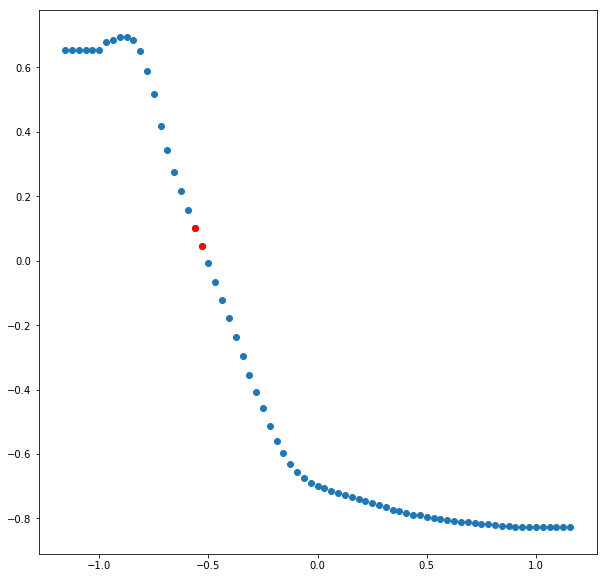

In [6]:
plt.figure(figsize = (10,10))
plt.scatter(vs[:, 0], mus[:,0])
plt.scatter(vs[19, 0], mus[19, 0], c="red")
plt.scatter(vs[20, 0], mus[20, 0], c="red")

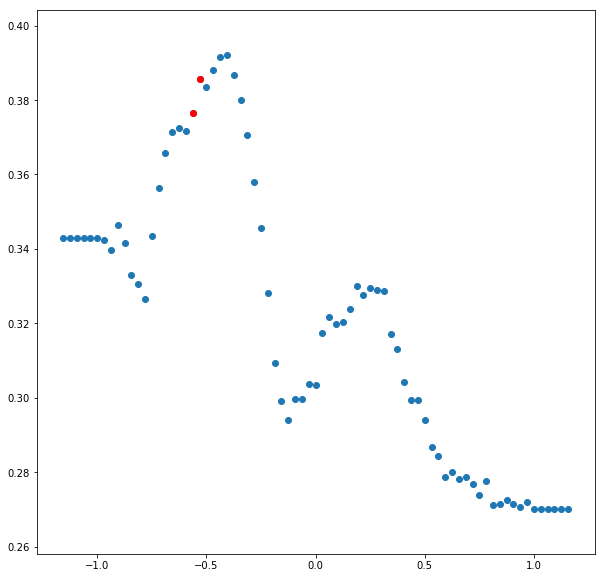

In [7]:
plt.figure(figsize = (10,10))
plt.scatter(vs[:, 0], sigs[:,0])
plt.scatter(vs[19, 0], sigs[19, 0], c="red")
plt.scatter(vs[20, 0], sigs[20, 0], c="red")

In [8]:
# pick 3 intermediate v vals to use 
v = np.linspace(vs[19, 0], vs[20, 0], 5)[1:4]
print(v)
print(vs[19,0],vs[20,0])

# (batch, n_mem)
v = np.array([v]*n_mem).T
v.shape

[-0.5546875 -0.546875  -0.5390625]
-0.5625 -0.53125


(3, 10)

In [9]:
# (n_p, n_mem)
print(vs.shape)
print(mus.shape)

(75, 10)
(75, 10)


In [10]:
# (batch, n_mem)
eps = np.zeros((3,n_mem))
print(eps.shape)

(3, 10)


In [11]:
interp_width = vs[1, 0] - vs[0, 0]

In [16]:
with tf.Session() as sess:
    interp_mus  = sess.run(gauss_interp(v, vs, mus, interp_width))
    interp_sigs = sess.run(gauss_interp(v, vs, sigs, interp_width))

In [17]:
interp_mus.shape

(3, 10)

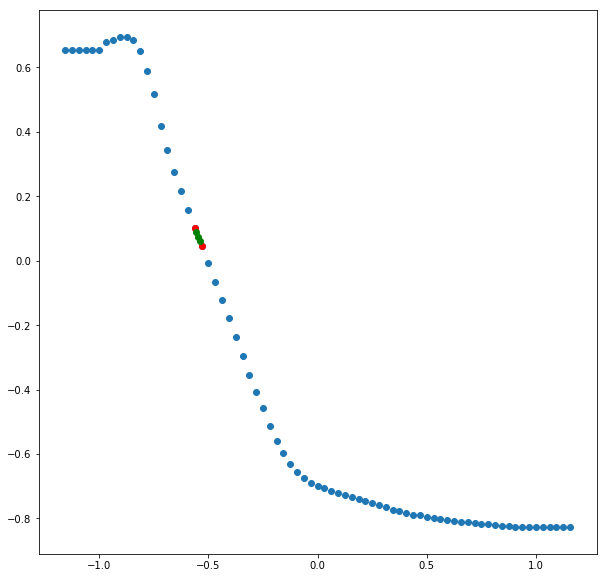

In [18]:
plt.figure(figsize = (10,10))
plt.scatter(vs[:, 0], mus[:,0])
plt.scatter(vs[19, 0], mus[19, 0], c="red")
plt.scatter(vs[20, 0], mus[20, 0], c="red")
plt.scatter(v[:,0], interp_mus[:, 0], c="green")

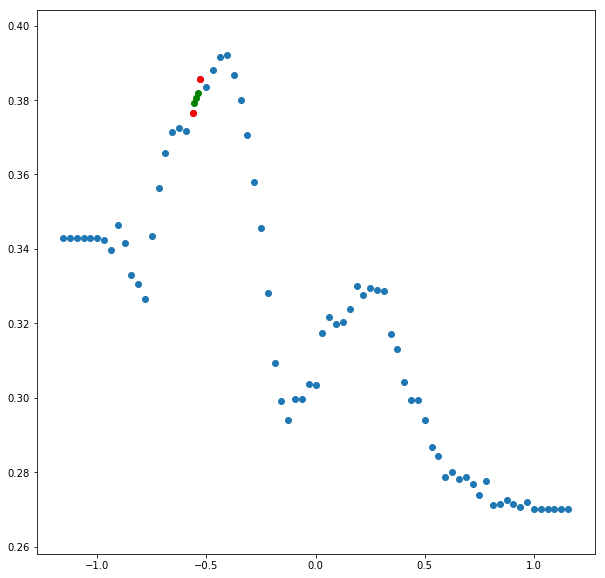

In [19]:
plt.figure(figsize = (10,10))
plt.scatter(vs[:, 0], sigs[:,0])
plt.scatter(vs[19, 0], sigs[19, 0], c="red")
plt.scatter(vs[20, 0], sigs[20, 0], c="red")
plt.scatter(v[:,0], interp_sigs[:, 0], c="green")